#  Cat Boost

The aim of this notebook is to try out XG-boost on our optimization problem. There is also some ideas and concepts that will overlap with other machine learning models. Some novel ideas related to the preprocessing step is in this file, but SHOULD be moved to a dedicated pre-processing library to make the puipeline easier to work with.

*TODO: Create a preprocessing library*

### Import the needed libraries

In [329]:
# First we will extract the data, and save it to a csv.
# Machine Learning Model
import catboost as cb

# Data Processing Tools
import numpy as np
import pandas as pd
import seaborn as sns

# Data Display Tools
import matplotlib.pyplot as plt

# Machine Learning Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import f_regression

import feature_generation as feat_gen
import data_processing as dat_proc

%matplotlib inline



### Extract data

In [330]:
# train_a = pd.read_parquet('A/train_targets.parquet')
# X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
# X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
# X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')

# print(train_a.info())

### Example for adding all the data -- Am

In [331]:
def add_clean_all(train: pd.DataFrame, observe: pd.DataFrame):
    con = pd.concat([train, observe], axis = 1) # Concatenate train and observe  #### ignore_index=True ??
    con_sort = con.sort_values(by = "time") # Sort by time
    # Interpolate missing values. limit_direction = "both"  make sure we get the first value
    # It will interpolate values both forward and backward from the missing data points to fill gaps in the data.
    con_pol = con_sort.interpolate(method = "linear", limit_direction = "both") 
    # con_dup = con_pol.drop_duplicates(subset = "time", keep = "first") # Remove duplicates from the time column
    con_nan = con_pol[~pd.isna(con_pol["pv_measurement"])]; # Remove rows with NaN in pv_measurement. ; is used to remove the print
    print("Number of NaN in pv_measurement: ", con_nan["pv_measurement"].isna().sum())
    con_clean = con_nan.reset_index(drop = True) # Reset index

    # print("Number of NaN in pv_measurement: ", con_clean["pv_measurement"].isna().sum())
    # print(con_clean.date_forecast)

    X = con_clean.drop(columns = ["time", "pv_measurement"], axis = 1) # drop_time  # "date_forecast", # date_calc if estimate is her
    y = con_clean[["time", "pv_measurement"]].copy()
    return X, y

# Read Data
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

# Merge data
X_all_a, y_all_a = add_clean_all(train_a, X_train_observed_a)
X_all_b, y_all_b = add_clean_all(train_b, X_train_observed_b)
X_all_c, y_all_c = add_clean_all(train_c, X_train_observed_c)

X_all = pd.concat([X_all_a,X_all_b,X_all_c], axis = 0)
y_all = pd.concat([y_all_a,y_all_b,y_all_c], axis = 0)

print(X_all.isna().sum().sum())
print(y_all.isna().sum().sum())


Number of NaN in pv_measurement:  0
Number of NaN in pv_measurement:  0
Number of NaN in pv_measurement:  0
0
0


### Preprocessing of data
Notice that we for now have a whole block dedicated to preprocessing, but should rather be its own module.

In [332]:
# Extract necesarry values for feature generation.
timestamps = "date_forecast"
measurements = list(X_all.columns.values)
measurements.remove(timestamps)

# Probable features that may be used
der_df = feat_gen.difference_df(X_all, timestamps, measurements)
int_df = feat_gen.daily_accumulated_val_df(X_all, timestamps, measurements)
dint_df = feat_gen.daily_accumulated_val_squared_df(X_all, timestamps, measurements)
time_df = feat_gen.time_data_from_df(X_all, timestamps)
# Removed duble derivited -- due to a lot of NaN values

In [333]:
# # print(X_all.date_forecast)
# print(der_df.isna().sum().sum())

# print(int_df.isna().sum().sum())
# print(dint_df.isna().sum().sum())
# print(time_df.isna().sum().sum())

# print(len(der_df))

# print(len(int_df))
# print(len(dint_df))
# print(len(time_df))

In [334]:
# Reset index of the DataFrames before concatenating
X_all = X_all.reset_index(drop=True) # Do all ready
der_df = der_df.reset_index(drop=True)
int_df = int_df.reset_index(drop=True)
dint_df = dint_df.reset_index(drop=True)
time_df = time_df.reset_index(drop=True)

In [335]:
# Concatenate the DataFrames
X = pd.concat([X_all, der_df, int_df, dint_df, time_df], axis="columns")
X = X.reset_index(drop=True)
# print(X.columns.values)

X = feat_gen.merge_features(X)  ###### Confused about this one. Removed date_forecast

In [336]:
# Additional features
der_y = feat_gen.difference_df(y_all, "time", ["pv_measurement"])
der_y_shifted = feat_gen.shifted_values_24_h(der_y, "derivative_pv_measurement_d") # derivative_pv_measurement_d column in der_y
y_shifted =  feat_gen.shifted_values_24_h(y_all, "pv_measurement")

In [338]:
X['date_forecast'] = X_all['date_forecast'] ## Add date forcasting for data lenght matching
# print(X.date_forecast)

# Adding together the added features to one dataframe.
y_BIG = pd.concat([y_all, der_y, der_y_shifted, y_shifted])
# print(y_all.columns.values)
# print(y_BIG.columns.values)
# print(X_all.columns.values)
# print(len(X), len(y_BIG))
# print(X.columns.values)

# Making sure that the two dataframes match in length.
y_BIG, X = dat_proc.data_length_matching(y_BIG, X)
# Get our desired output
y = y_BIG["pv_measurement"]  # Why not pv_measurement?
y = y.reset_index(drop = True)

# Removing datetime object column
y_features = y_BIG.drop(['pv_measurement', 'derivative_pv_measurement_d', 'time'], axis=1)
# y_features = y_features.drop('derivative_pv_measurement_d', axis=1)
# y_features = y_features.drop('time', axis=1)
y_features = y_features.reset_index(drop = True)

In [339]:

# Removing datetime object column
X = X.reset_index(drop = True)
X = X.drop([timestamps], axis=1)

X = pd.concat([X, y_features], axis = "columns")
# X = pd.concat([X, y_BIG], axis = "columns")

In [344]:
all_nan_columns = X.columns[X.isna().all()]                     ###### NÅ værende problem 
print("Columns with all NaN values:", all_nan_columns)
X = X.drop(columns=all_nan_columns)

Columns with all NaN values: Index(['derivative_pv_measurement_dn-1', 'derivative_pv_measurement_dn-2',
       'derivative_pv_measurement_dn-3', 'derivative_pv_measurement_dn-4',
       'derivative_pv_measurement_dn-5', 'derivative_pv_measurement_dn-6',
       'derivative_pv_measurement_dn-7', 'derivative_pv_measurement_dn-8',
       'derivative_pv_measurement_dn-9', 'derivative_pv_measurement_dn-10',
       'derivative_pv_measurement_dn-11', 'derivative_pv_measurement_dn-12',
       'derivative_pv_measurement_dn-13', 'derivative_pv_measurement_dn-14',
       'derivative_pv_measurement_dn-15', 'derivative_pv_measurement_dn-16',
       'derivative_pv_measurement_dn-17', 'derivative_pv_measurement_dn-18',
       'derivative_pv_measurement_dn-19', 'derivative_pv_measurement_dn-20',
       'derivative_pv_measurement_dn-21', 'derivative_pv_measurement_dn-22',
       'derivative_pv_measurement_dn-23', 'derivative_pv_measurement_dn-24',
       'pv_measurementn-1', 'pv_measurementn-2', 'pv_mea

In [345]:
# DO we get a day or the 
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()

# Fit and transform the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## AI Training: CatBoost


In [346]:

train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

model = cb.CatBoostRegressor(loss_function="RMSE", logging_level='Silent')

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset, verbose=False)


pred = model.predict(X_test)
mae = (mean_absolute_error(y_test, pred))
r2 = r2_score(y_test, pred)
print("Testing performance")
print("Mean Abs: {:.2f}".format(mae))
print("R2: {:.2f}".format(r2))



Testing performance
Mean Abs: 408.80
R2: -0.03


In [347]:
N = 100

feature_importance = model.get_feature_importance()

# Pair feature names with their importance scores
feature_importance_dict = dict(zip(model.feature_names_, feature_importance))

# Sort features by importance
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print or use the top features
top_features = sorted_feature_importance[:N]  # Replace N with the number of top features you want
print(top_features)
labels = list(X.columns.values)

for feat in top_features:
    print(labels[int(feat[0])])


[('2', 4.258832001720242), ('6', 4.181003497110059), ('117', 2.923313842018176), ('159', 2.479888062012731), ('5', 2.327948895573301), ('53', 2.291912878020815), ('180', 1.9716302186503225), ('147', 1.839388136442273), ('101', 1.7253755439631802), ('167', 1.7017367531768521), ('181', 1.6673027917332366), ('163', 1.5880285314823235), ('176', 1.5549054368000872), ('63', 1.5251407817165372), ('78', 1.5139158280839289), ('0', 1.476874389119885), ('162', 1.4728894410626054), ('94', 1.3271096809575103), ('178', 1.2946677176566173), ('104', 1.2938385696334567), ('116', 1.262905324169079), ('172', 1.1660513620917052), ('179', 1.149726160697393), ('12', 1.094232160172319), ('47', 1.0801716009858469), ('121', 1.0756120273731062), ('131', 1.0479571314917662), ('113', 1.0340498928171888), ('1', 1.0107942263600755), ('166', 1.0002823012256734), ('42', 0.9513930802775581), ('35', 0.9488141104187272), ('92', 0.9329953430392183), ('148', 0.9315389449363954), ('103', 0.9241516728614432), ('100', 0.8963

### Plotting
Adding a set of plotts to see how well the machine-learning model performs graphically.

TODO: We should probably plot the data-values that perform the worst.

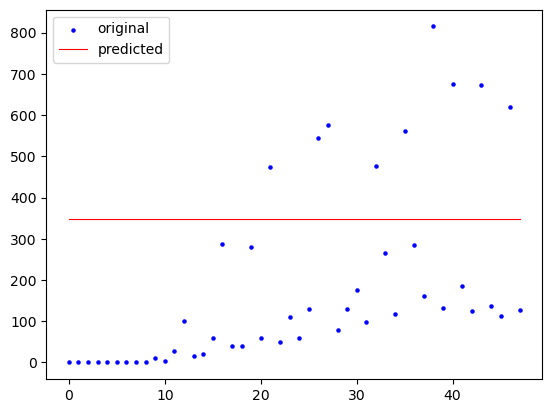

In [348]:


x_ax = range(48)
plt.scatter(x_ax, y_test[0:48], s=5, color="blue", label="original")
plt.plot(x_ax, pred[0:48], lw=0.8, color="red", label="predicted")

plt.legend()
plt.show()
